# Project

In [3]:
# enable auto reload
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

## 1. Load Preprocessed Data

In [5]:
RAW_PATH = './data'            # path to raw data
NP_PATH = './preprocessed'     # path to preprocessed data
FRAME_LEN = 1024               # length of one data frame
FRAME_INTV = 512               # interval between data frames

if not os.path.exists(NP_PATH):
    os.mkdir(NP_PATH)

In [9]:
from src.utils.data_utils import get_preprocessed_data
### for more information, please look up <get_preprocessed_data> in
### './src/utils/data_utils.py'

DATA, train_idx, test_idx, trainY, testY, train_diameter, test_diameter, train_rpm, test_rpm = get_preprocessed_data(RAW_PATH, NP_PATH, FRAME_LEN, FRAME_INTV)

## 2. Semisupervised Learning!!!!

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=True

you can modify the source

In [12]:
SAVE_PATH = './saved_models'
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [19]:
MASK_P = 0.01
SCREEN_LABEL = 1
SCREEN_DIAM = 2

MASK_PARAMS = {
    'mask_p' : MASK_P,
    'screen_label' : SCREEN_LABEL,
    'screen_diam' : SCREEN_DIAM,
    'trainY' : trainY,
    'train_diameter' : train_diameter
}

In [20]:
from src.utils.data_utils import get_shuffle_n_mask

train_shuffle, val_shuffle, MASK = get_shuffle_n_mask(train_idx.shape[0], mask_params=MASK_PARAMS)

SEED : 0
# of labeled data : 139
# of unlabeled data : 13827
percentage : 1.00%


# Your code from here

In [15]:
### YOU CAN IMPORT ANY INTERNAL/EXTERNAL LIBRARIES HERE

In [16]:
### YOU CAN MODIFY FOLLOWING CONFIGURATIONS
LR = 1e-3        # learning rate of the optimizer
BATCH = 128      # batch size
EPOCH = 500      # maximum epochs to run
TOL = 10         # if best valid loss does not get updated for TOL epochs, early stop training
SAV_INTV = 10    # save model weights in every SAV_INTV epoch

In [22]:
MODEL_NAME = 'ProjectModel1'

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ### YOUR CODE FROM HERE
        
        ### TO HERE
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m)==nn.Linear or type(m)==nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        ### YOUR CODE FROM HERE
        
        return NotImplementedError
        ### TO HERE
    def get_latent(self, x):
        ### YOUR CODE FROM HERE
        
        return NotImplementedError
        ### TO HERE
    ### YOU CAN ADD ANY FUNCTIONS/INSTANCES INSIDE THE CLASS

In [11]:
def batch_step(model, X, Y, M=None, train=False, optimizer=None):
    if M is None:
        M = torch.zeros_like(Y) == 0
        M = M.to(device=DEVICE, dtype=torch.bool)
        
    ### YOUR CODE FROM HERE
    
    ### TO HERE
    
    return class_loss, correct, wrong

In [1]:
### YOU CAN ALSO MODIFY the function <epoch_step> in 
### './src/utils/data_utils.py', but be careful!!

In [51]:
#for debugging
from src.models.SimpleModel import SimpleModel as MyModel
from src.experiment import batch_step

In [52]:
model = MyModel()
model.cuda()

### IF YOU WANT, YOU ALSO CAN MODIFY THE OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr=LR)

In [53]:
np.save('%s/%s_mask.npy'%(SAVE_PATH, MODEL_NAME), MASK)

In [54]:
TRAIN_PARAMS = {
    'model' : model,
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : MODEL_NAME,
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : MASK,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [55]:
from src.experiment import train
train(**TRAIN_PARAMS)

(1.61s)[Epoch 1]
	(train) loss : 1.36719,	acc : 0.22055
	(eval) loss : 1.17314,	acc : 0.22405
(1.63s)[Epoch 2]
	(train) loss : 1.31679,	acc : 0.21867
	(eval) loss : 1.17993,	acc : 0.21654
(1.58s)[Epoch 3]
	(train) loss : 1.26982,	acc : 0.29672
	(eval) loss : 1.16428,	acc : 0.30315
(1.52s)[Epoch 4]
	(train) loss : 1.23412,	acc : 0.34569
	(eval) loss : 1.15928,	acc : 0.39155


KeyboardInterrupt: 

In [56]:
TEST_PARAMS = {
    'model' : model,
    'data' : DATA,
    'model_name' : MODEL_NAME,
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [57]:
from src.experiment import test
test(**TEST_PARAMS, test_idx=test_idx, testY=testY)

Test Result of model <ProjectModel1>:best
  [Loss]	1.68224
  [Accuracy]	39.70%


In [60]:
print('[EVALUATE TRAIN DATA]')
test(**TEST_PARAMS, test_idx=train_idx, testY=trainY)
print('\n[EVALUATE LABELED DATA]')
test(**TEST_PARAMS, test_idx=train_idx[MASK], testY=trainY[MASK])
print('\n[EVALUATE UNLABELED DATA]')
test(**TEST_PARAMS, test_idx=train_idx[~MASK], testY=trainY[~MASK])

[EVALUATE TRAIN DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	1.68142
  [Accuracy]	39.49%

[EVALUATE LABELED DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	1.62570
  [Accuracy]	35.97%

[EVALUATE UNLABELED DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	1.68203
  [Accuracy]	39.11%


In [69]:
from src.utils.plot_utils import *
from src.experiment import get_latents
from sklearn.manifold import TSNE


In [67]:
z, preds = get_latents(**TEST_PARAMS, test_idx=test_idx, testY=testY)
z = z.cpu().numpy()
preds = preds.cpu().numpy()
print(z.shape, preds.shape)

(3539, 32) (3539,)


In [70]:
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


<IPython.core.display.Javascript object>


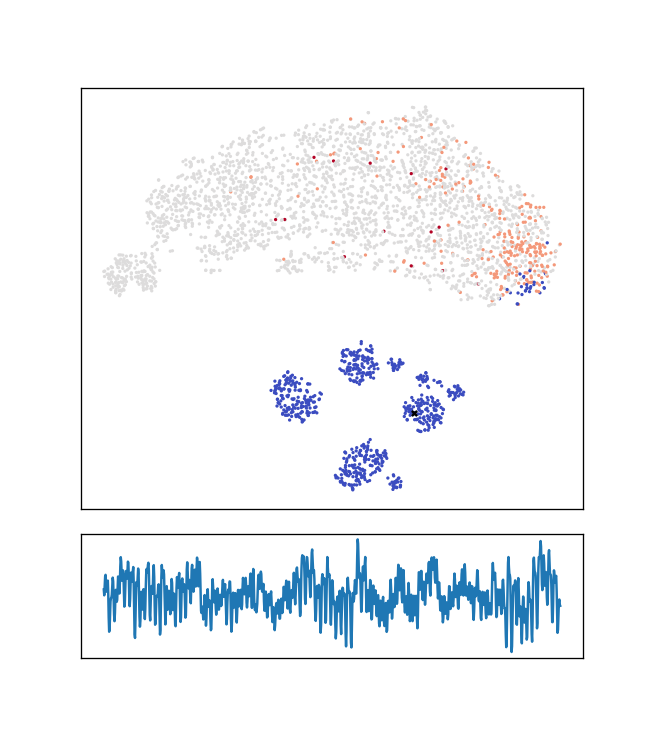

In [71]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

report generate code?